## This notebook attempts to train and validate a DCTR model paramterized by the top mass

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras
import keras.backend as K

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Check versions
print(keras.__version__) #2.2.4

2.2.4


# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    # for x in X: 
        # normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=4)
    return X

## Process Data

In [6]:
# Path to downloaded data from Zenodo
data_dir0 = '/data1/users/aandreassen/DCTRFitting/'
data_dir1 = '/data1/users/asuresh/DCTRFitting/'

In [7]:
train_dataset_0_x4 = np.load(data_dir1 + 'part_172_5_6j_x4.npy')
train_dataset_1_x4 = np.load(data_dir1 + 'part_varmass_6j_x4.npy')

train_dataset_0 = np.load(data_dir0 + 'part_172_5_6j.npy')
train_dataset_1 = np.load(data_dir0 + 'part_varmass_6j.npy')

In [8]:
X0 = np.concatenate([train_dataset_0, train_dataset_0_x4])
# shorten X1 to same length as X0   
# s.t. network sees an equal number 
# of examples from X0 and X1        

X1 = np.concatenate([train_dataset_1, train_dataset_1_x4])#[0:len(X0)]

print(np.shape(X0))
print(np.shape(X1))
print(len(X1)/(len(X0)+len(X1))) # X1 percentage of training data 

(287065, 6, 5)
(1179284, 6, 5)
0.8042314619507361


In [9]:
# Zip uniformally sampled top mass in part_varmass_6j
# with part_172_5_6j


# for i in range(len(X1)):
#     for j in range(6):
#         X0[i, j, 4] = X1[i, j, 4]

# X0 already zipped with mT uniformally sampled

In [10]:
Y0 = np.zeros_like(X0[:,0,0])
Y1 = np.ones_like(X1[:,0,0])

In [11]:
X = np.concatenate((X0, X1), axis = 0)

Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [12]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True)

In [13]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(1319715, 6, 5)
(1319715, 2)
(146634, 6, 5)
(146634, 2)


# Build Model

In [14]:
# network architecture parameters
Phi_sizes = (200,200, 256)
F_sizes = (200,200, 200)

dctr = PFN(input_dim=5, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)



# Train model

In [15]:
save_label = 'TOP_DCTR'

checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='min')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [checkpoint, EarlyStopping]

In [16]:
n_fail1 = 0
n_fail2 = 0
n_succ = 0
iterations = 100
for i in range(iterations):
    print("Iteration: ", i)
    
    K.clear_session()
    dctr = PFN(input_dim=5, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)
    history = dctr.fit(X_train, Y_train,
                        epochs = 1,
                        batch_size = 1000,
                        validation_data = (X_val, Y_val),
                        verbose = 1)
    
    if history.history['val_loss'][0] > 2: # Fail case 1
        n_fail1 += 1
    elif history.history['val_loss'][0] < 0.1: # Fail case 2
        n_fail2 += 1
    else: # success
        n_succ += 1
        # serialize weights to HDF5
        dctr.save_weights("TOP_DCTR.h5")
        print("Saved model to disk")
            
n_fail = n_fail1 + n_fail2

Iteration:  0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1319715 samples, validate on 146634 samples
Epoch 1/1





1319715/1319715 [==============================] - 33s 25us/step - loss: 3.1598 - acc: 0.8040 - val_loss: 3.1158 - val_acc: 0.8067
Iteration:  1
Train on 1319715 samples, validate on 146634 samples
Epoch 1/1
1319715/1319715 [==============================] - 32s 24us/step - loss: 3.1598 - acc: 0.8040 - val_loss: 3.1158 - val_acc: 0.8067
Iteration:  2
Train on 1319715 samples, validate on 146634 samples
Epoch 1/1
1319715/1319715 [==============================] - 35s 27us/step - loss: 3.1598 - acc: 0.8040 - val_loss: 3.1158 - val_acc: 0.8067
Iteration:  3
Train on 1319715 samples, validate on 146634 samples
Epoch 1/1
1319715/1319715 [==============================] - 36s 27us/step - loss: 12.9583 - acc: 0.1960 - val_loss: 13.0023 - val_acc: 0.1933
Iteration:  4
Train on 1319715 samples, validate on 146634 sam

1319715/1319715 [==============================] - 36s 27us/step - loss: 10.0048 - acc: 0.3793 - val_loss: 3.1158 - val_acc: 0.8067
Iteration:  67
Train on 1319715 samples, validate on 146634 samples
Epoch 1/1
1319715/1319715 [==============================] - 40s 30us/step - loss: 12.9583 - acc: 0.1960 - val_loss: 13.0023 - val_acc: 0.1933
Iteration:  68
Train on 1319715 samples, validate on 146634 samples
Epoch 1/1
1319715/1319715 [==============================] - 39s 30us/step - loss: 3.1598 - acc: 0.8040 - val_loss: 3.1158 - val_acc: 0.8067
Iteration:  69
Train on 1319715 samples, validate on 146634 samples
Epoch 1/1
1319715/1319715 [==============================] - 41s 31us/step - loss: 12.9583 - acc: 0.1960 - val_loss: 13.0023 - val_acc: 0.1933
Iteration:  70
Train on 1319715 samples, validate on 146634 samples
Epoch 1/1
1319715/1319715 [==============================] - 41s 31us/step - loss: 3.1598 - acc: 0.8040 - val_loss: 3.1158 - val_acc: 0.8067
Iteration:  71
Train on 1319

In [19]:
n_fail = n_fail1 + n_fail2

print("Number of initializations failed: ", n_fail, "/", iterations)
print("Percentage of initializations failed:", (100*n_fail/iterations), "%")

print("Number of initializations succeeded: ", n_succ, "/", iterations)
print("Percentage of initializations succeeded:", (100*n_succ/iterations), "%")

Number of initializations failed:  100 / 100
Percentage of initializations failed: 100.0 %
Number of initializations succeeded:  0 / 100
Percentage of initializations succeeded: 0.0 %


Finish training

In [20]:
try:
    dctr_model.load_weights("TOP_DCTR.h5")
    history = dctr.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 1000,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)
except:
    print("Model had 0 successful initializations, will not finish training")

Model had 0 successful initializations, will not finish training


# Plot History

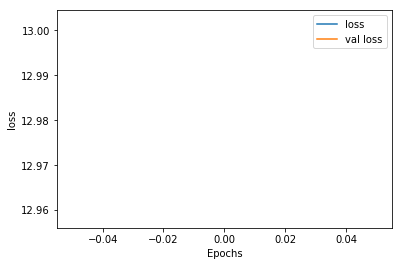

In [21]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

## Load Datasets

In [23]:
test_dataset_0 = np.load(data_dir0+'part_172_5_6j.npy')
test_dataset_1 = np.load(data_dir0+'part_175_0_6j.npy')

In [24]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get predictions

In [27]:
# Load test datasets
X0_test = test_dataset_0 # preprocess_data(test_dataset_0)
X1_test = test_dataset_1 # preprocess_data(test_dataset_1)



In [28]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_test, batch_size=1000)
preds_1 = dctr.predict(X1_test, batch_size=1000)

In [29]:
print(preds_0[0:20]) # Network hasn't trained 

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## Get weights

In [30]:
weights_0 = preds_0[:,1]/preds_0[:,0]
weights_1 = preds_1[:,1]/preds_1[:,0]

## Analyze weights

In [31]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

0.0
inf
0.0
inf


/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


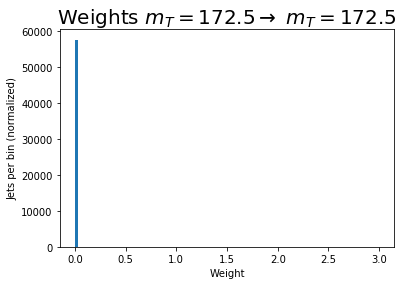

In [32]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
plt.show()

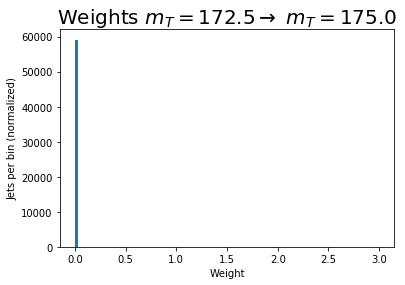

In [33]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
plt.show()